# Comparing VulnCheck Known Exploited Vulnerabilties & CISA KEV

## Initial Configuration

In [14]:
import os
import vulncheck_sdk
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import calplot

DEFAULT_HOST = "https://api.vulncheck.com"
DEFAULT_API = DEFAULT_HOST + "/v3"
# TOKEN = "INSERT_TOKEN"  # Replace with your actual API token
TOKEN = os.environ["VULNCHECK_API_TOKEN"]
YEAR = 2025

# Configure the VulnCheck API client
configuration = vulncheck_sdk.Configuration(host=DEFAULT_API)
configuration.api_key["Bearer"] = TOKEN

## Pull Data

In [18]:
with vulncheck_sdk.ApiClient(configuration) as api_client:
    indices_client = vulncheck_sdk.IndicesApi(api_client)

    limit = 200

    # Initialize lists to store vendor and CVE data
    cve = []
    vendor = []
    product = []
    ransomware = []
    date_added = []
    cisa_date_added = []

    # Make the initial request to start pagination
    api_response = indices_client.index_vulncheck_kev_get(start_cursor="true", limit=limit)

    # Process the first page of results
    for entry in api_response.data:
        # Directly access the first element of the list
        cve.append(entry.cve[0])  # Since there is always one CVE in the list
        vendor.append(entry.vendor_project)
        product.append(entry.product)
        ransomware.append(entry.known_ransomware_campaign_use)
        date_added.append(entry.date_added[:10])

        # Handle cisa_date_added when it's None or has a date
        if entry.cisa_date_added is None:
            cisa_date_added.append("none")
        else:
            cisa_date_added.append(entry.cisa_date_added[:10])

    # Continue fetching data while there's a next cursor
    while api_response.meta.next_cursor is not None:

        # Fetch the next page using the cursor
        api_response = indices_client.index_vulncheck_kev_get(
            cursor=api_response.meta.next_cursor, limit=limit
        )

        # Append the new data from the next page
        for entry in api_response.data:
            cve.append(entry.cve[0])
            vendor.append(entry.vendor_project)
            product.append(entry.product)
            ransomware.append(entry.known_ransomware_campaign_use)
            date_added.append(entry.date_added[:10])

            # Handle cisa_date_added when it's None or has a date
            if entry.cisa_date_added is None:
                cisa_date_added.append("none")
            else:
                cisa_date_added.append(entry.cisa_date_added[:10])

# Create a DataFrame from the accumulated data
df_original = pd.DataFrame({
    'CVE': cve,
    'Vendor': vendor,
    'Product': product,
    'Ransomware': ransomware,
    'Date Added': date_added,
    'CISA Date Added': cisa_date_added
})

## 2025 Known Exploited Vulnerabilities Statistics (Year-to-Date)

In [19]:
df = df_original.copy()

df['Date Added'] = pd.to_datetime(df['Date Added'])
df['CISA Date Added'] = df['CISA Date Added'].replace('none', pd.NaT)
df['CISA Date Added'] = pd.to_datetime(df['CISA Date Added'], format='%Y-%m-%d', errors='coerce')

# Get the current date and calculate the number of months passed in the year
current_date = df['Date Added'].max()  # Use the latest date in 'Date Added'
months_passed = current_date.month if current_date.year == YEAR else 12  # Use full 12 months for past years

# VulnCheck KEV data for the specified year
df_vulncheck_year = df[df['Date Added'].dt.year == YEAR]
total_kevs_vulncheck = df_vulncheck_year['CVE'].nunique()
avg_kevs_per_month_vulncheck = total_kevs_vulncheck / months_passed

# CISA KEV data where 'CISA Date Added' is within the specified year
df_cisa_year = df[df['CISA Date Added'].dt.year == YEAR]
total_kevs_cisa = df_cisa_year['CVE'].nunique()
avg_kevs_per_month_cisa = total_kevs_cisa / months_passed

# Unique vendors and products for VulnCheck KEV
unique_vendors_vulncheck = df_vulncheck_year['Vendor'].nunique()
unique_products_vulncheck = df_vulncheck_year['Product'].nunique()

# Unique vendors and products for CISA KEV
unique_vendors_cisa = df_cisa_year['Vendor'].nunique()
unique_products_cisa = df_cisa_year['Product'].nunique()

# Compile statistics into a structured DataFrame with multi-level columns
stats_df = pd.DataFrame({
    ("Total KEVs Added", "VulnCheck KEV"): [total_kevs_vulncheck],
    ("Total KEVs Added", "CISA KEV"): [total_kevs_cisa],
    ("Avg. KEVs per month", "VulnCheck KEV"): [avg_kevs_per_month_vulncheck],
    ("Avg. KEVs per month", "CISA KEV"): [avg_kevs_per_month_cisa],
    ("Unique Vendors", "VulnCheck KEV"): [unique_vendors_vulncheck],
    ("Unique Vendors", "CISA KEV"): [unique_vendors_cisa],
    ("Unique Products", "VulnCheck KEV"): [unique_products_vulncheck],
    ("Unique Products", "CISA KEV"): [unique_products_cisa],
})

# Set the year as the index
stats_df.index = [YEAR]

style = [{'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}]

# Apply styling for centered text in both headers and cells and format averages to 1 decimal point
styled_stats_df = stats_df.style \
    .format({("Avg. KEVs per month", "VulnCheck KEV"): "{:.1f}", 
                ("Avg. KEVs per month", "CISA KEV"): "{:.1f}"}) \
    .set_table_styles({
        ('Total KEVs Added', 'VulnCheck KEV'): style,
        ('Total KEVs Added', 'CISA KEV'): style,
        ('Avg. KEVs per month', 'VulnCheck KEV'): style,
        ('Avg. KEVs per month', 'CISA KEV'): style,
        ('Unique Vendors', 'VulnCheck KEV'): style,
        ('Unique Vendors', 'CISA KEV'): style,
        ('Unique Products', 'VulnCheck KEV'): style,
        ('Unique Products', 'CISA KEV'): style
    }).set_properties(**{'text-align': 'center'}) \
    .set_caption(f"<b>{YEAR} Year-to-Date KEV Statistics</b>") \
    .set_table_attributes('style="width:100%; border-collapse: collapse;"')

styled_stats_df


## 2025 Known Exploited Vulnerabilities by Vendor nd Product - Year-to-Date (Source:VulnCheck KEV)

In [21]:
df = df_original.copy()

# Convert 'Date Added' to datetime format
df['Date Added'] = pd.to_datetime(df['Date Added'], errors='coerce')

# Filter for entries where 'Date Added' is in the current year
current_year = df[(df['Date Added'].dt.year == YEAR)]

# Count occurrences by Vendor and Product for the current year
vendor_product_counts = current_year.groupby(['Vendor', 'Product']).size().reset_index(name='Counts')

# Truncate vendor and product names to 15 characters for readability
vendor_product_counts['Vendor'] = vendor_product_counts['Vendor'].str.slice(0, 15)
vendor_product_counts['Product'] = vendor_product_counts['Product'].str.slice(0, 15)

# Create a treemap with both Vendor and Product levels
fig = px.treemap(vendor_product_counts, path=['Vendor', 'Product'], values='Counts', 
                 color='Counts', color_continuous_scale='Viridis')

# Customize the title and layout for dark mode with specific width and height
fig.update_layout(
    title=f"Known Exploited Vulnerabilities by Vendor and Product - {YEAR} (Source: VulnCheck KEV)",
    title_font=dict(size=20, color='white'),
    title_x=0.5,
    paper_bgcolor='black',
    plot_bgcolor='black',
    margin=dict(t=50, l=25, r=25, b=25),
    width=1800,
    height=1000
)

# Remove color bar by setting coloraxis_showscale to False
fig.update_coloraxes(showscale=False)

# Use default font for labels inside the treemap (Arial) by removing custom font settings
fig.update_traces(
    texttemplate='%{label}<br> %{value}', 
    textfont_size=16,
    textfont_color='white'
)

# Display the figure
fig.show()


## 2025 Known Exploited Vulnerabilities by Vendor nd Product - Year-to-Date (Source:CISA KEV)

In [22]:
df = df_original.copy()

# Step 2: Convert 'CISA Date Added' to datetime format with a specified format
# Replace '%Y-%m-%d' with the actual format of your dates if different
df['CISA Date Added'] = pd.to_datetime(df['CISA Date Added'], format='%Y-%m-%d', errors='coerce')

# Step 3: Drop rows where 'CISA Date Added' could not be parsed
df.dropna(subset=['CISA Date Added'], inplace=True)

# Step 4: Filter for entries where 'CISA Date Added' is from this year
filtered_data = df[df['CISA Date Added'].dt.year == YEAR]

# Step 5: Count occurrences by Vendor and Product for entries with CISA Date Added in this year
vendor_product_counts = filtered_data.groupby(['Vendor', 'Product']).size().reset_index(name='Counts')

# Truncate vendor and product names to 15 characters for readability
vendor_product_counts['Vendor'] = vendor_product_counts['Vendor'].str.slice(0, 15)
vendor_product_counts['Product'] = vendor_product_counts['Product'].str.slice(0, 15)


# Create a treemap with both Vendor and Product levels
fig = px.treemap(vendor_product_counts, path=['Vendor', 'Product'], values='Counts', 
                 color='Counts', color_continuous_scale='Viridis')

# Customize the title and layout for dark mode with specific width and height
fig.update_layout(
    title=f"Known Exploited Vulnerabilities by Vendor and Product - {YEAR} CISA Entries (Source: CISA KEV)",
    title_font=dict(size=20, color='white'),
    title_x=0.5,
    paper_bgcolor='black',
    plot_bgcolor='black',
    margin=dict(t=50, l=25, r=25, b=25),
    width=1800,
    height=1000
)

# Remove color bar by setting coloraxis_showscale to False
fig.update_coloraxes(showscale=False)

# Use default font for labels inside the treemap (Arial) by removing custom font settings
fig.update_traces(
    texttemplate='%{label}<br> %{value}', 
    textfont_size=16,  # Font size for readability
    textfont_color='white'  # Font color
)

# Display the figure
fig.show()

## 2025 Known Exploited Vulnerabilities by Day - Year-to-Date (Source:Vulncheck KEV)

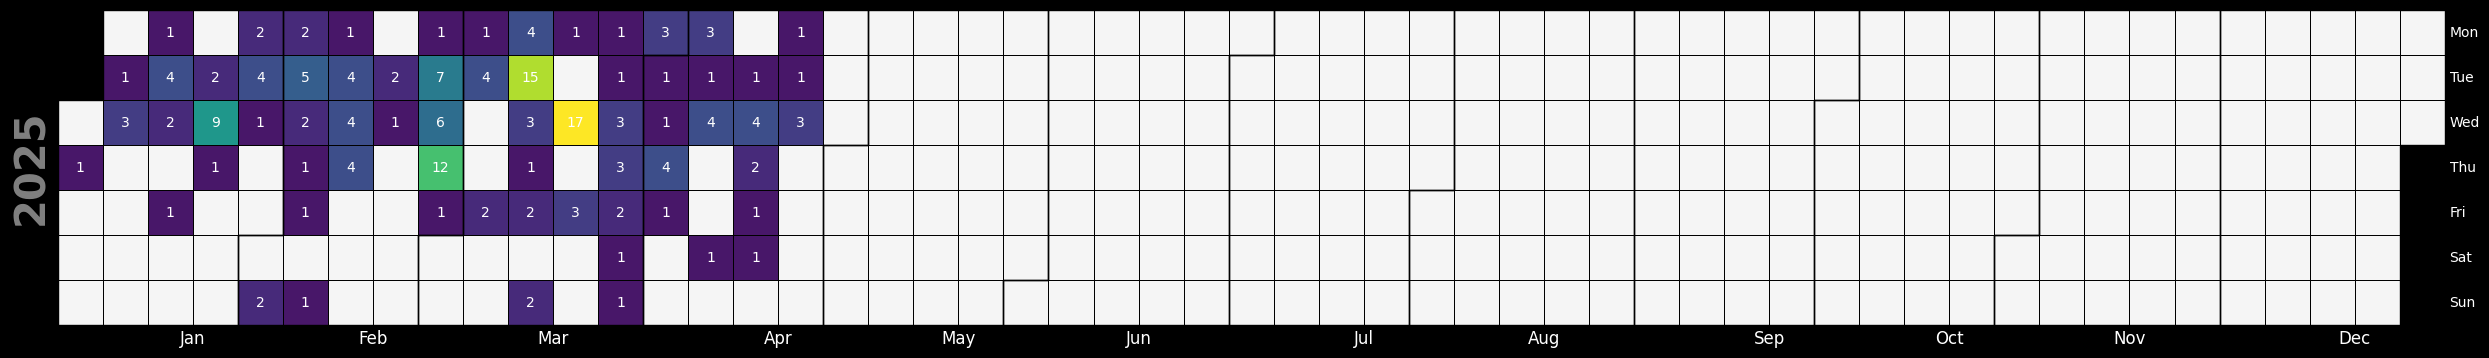

In [23]:
df = df_original.copy()

# Title text
title_text = f"First Seen Exploitation Evidence per Unique CVE in {YEAR} (Source: VulnCheck KEV)"

# Step 1: Convert 'Date Added' to datetime format, handling errors
df['Date Added'] = pd.to_datetime(df['Date Added'], errors='coerce')

# Step 2: Drop rows where 'Date Added' could not be parsed
df = df.dropna(subset=['Date Added'])

# Step 3: Filter for entries where 'Date Added' is from this year
df_filtered = df[df['Date Added'].dt.year.isin([YEAR])]

# Step 4: Count occurrences of each 'Date Added' date
date_counts = df_filtered['Date Added'].value_counts().sort_index()

# Step 5: Convert the counts to a DataFrame for plotting
date_counts_df = date_counts.to_frame(name='Counts')

# Step 6: Set a continuous date range from Jan 1 to Dev 31
full_date_range = pd.date_range(start=f"{YEAR}-01-01", end=f"{YEAR}-12-31")

# Step 7: Reindex the DataFrame with the full date range, filling missing dates with zero counts
date_counts_df = date_counts_df.reindex(full_date_range, fill_value=0)

# Step 8: Plot the calendar heatmap for each year from this year using calplot
fig, ax = calplot.calplot(
    date_counts_df['Counts'],
    cmap='viridis',
    vmin=0,
    vmax=date_counts_df['Counts'].max(),
    colorbar=False,
    dropzero=True,
    edgecolor="black",
    textcolor="white",
    textformat='{:.0f}',
    figsize=(25, 10),
    yearascending=False,
    yearlabel_kws={'fontname':'sans-serif'}
)

# Set the figure and axes background to black
fig.patch.set_facecolor('black')
for a in ax:
    a.set_facecolor('black')

# Modify the month and day labels to be white
for a in ax:
    # Set month labels to white
    for label in a.get_xticklabels():
        label.set_color("white")
        label.set_fontsize(12)
        label.set_fontfamily('sans-serif')
    # Set day labels to white
    for label in a.get_yticklabels():
        label.set_color("white")
        label.set_fontsize(10)
        label.set_fontfamily('sans-serif')

# Manually add black borders around each day cell
for a in ax:
    for collection in a.collections:
        collection.set_edgecolor("black") 
        collection.set_linewidth(0.5)

plt.show()


## 2025 Known Exploited Vulnerabilities by Day - Year-to-Date (Source:CISA KEV)

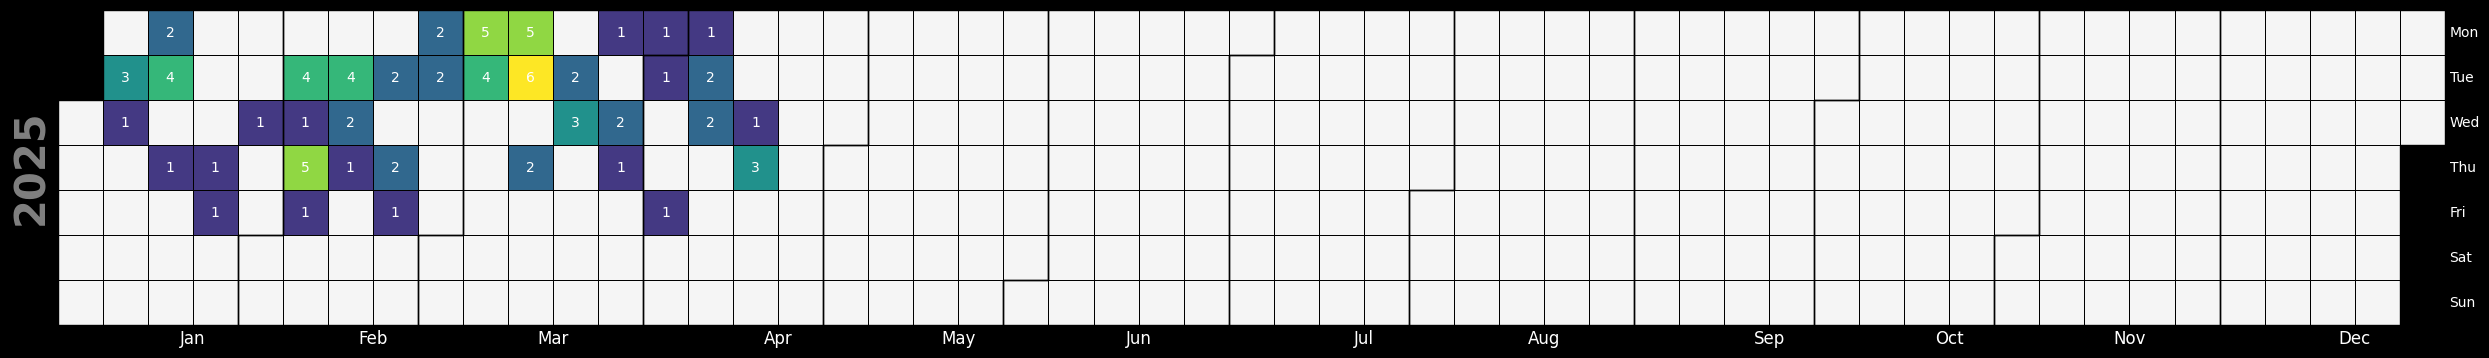

In [24]:
df = df_original.copy()

# Title text
title_text = f"CISA KEV Added Date per Unique CVE in {YEAR} (Source: CISA KEV)"

# Step 1: Convert 'CISA Date Added' to datetime format, handling errors
df['CISA Date Added'] = pd.to_datetime(df['CISA Date Added'], errors='coerce', format='mixed')

# Step 2: Drop rows where 'CISA Date Added' could not be parsed
df.dropna(subset=['CISA Date Added'], inplace=True)

# Step 3: Filter for entries where 'CISA Date Added' is from the current year
df_filtered = df[df['CISA Date Added'].dt.year == YEAR]

# Step 4: Count occurrences of each 'CISA Date Added' date
date_counts = df_filtered['CISA Date Added'].value_counts().sort_index()

# Step 5: Convert the counts to a DataFrame for plotting
date_counts_df = date_counts.to_frame(name='Counts')

# Step 6: Set a continuous date range from Jan 1 to Dev 31
full_date_range = pd.date_range(start=f"{YEAR}-01-01", end=f"{YEAR}-12-31")

# Step 7: Reindex the DataFrame with the full date range, filling missing dates with zero counts
date_counts_df = date_counts_df.reindex(full_date_range, fill_value=0)

fig, ax = calplot.calplot(
    date_counts_df['Counts'],
    cmap='viridis',
    vmin=0,
    vmax=date_counts_df['Counts'].max(),
    colorbar=False,
    dropzero=True,
    edgecolor="black",
    textcolor="white",
    textformat='{:.0f}',
    figsize=(25, 10),
    yearascending=False,
    yearlabel_kws={'fontname':'sans-serif'}
)

# Set the figure and axes background to black
fig.patch.set_facecolor('black')
for a in ax:
    a.set_facecolor('black')

# Modify the month and day labels to be white
for a in ax:
    # Set month labels to white
    for label in a.get_xticklabels():
        label.set_color("white")
        label.set_fontsize(12)
        label.set_fontfamily('sans-serif')
    # Set day labels to white
    for label in a.get_yticklabels():
        label.set_color("white")
        label.set_fontsize(10)
        label.set_fontfamily('sans-serif')

# Manually add black borders around each day cell
for a in ax:
    for collection in a.collections:
        collection.set_edgecolor("black")
        collection.set_linewidth(0.5)

plt.show()


## Exploitation Evidence Availability Before CISA KEV

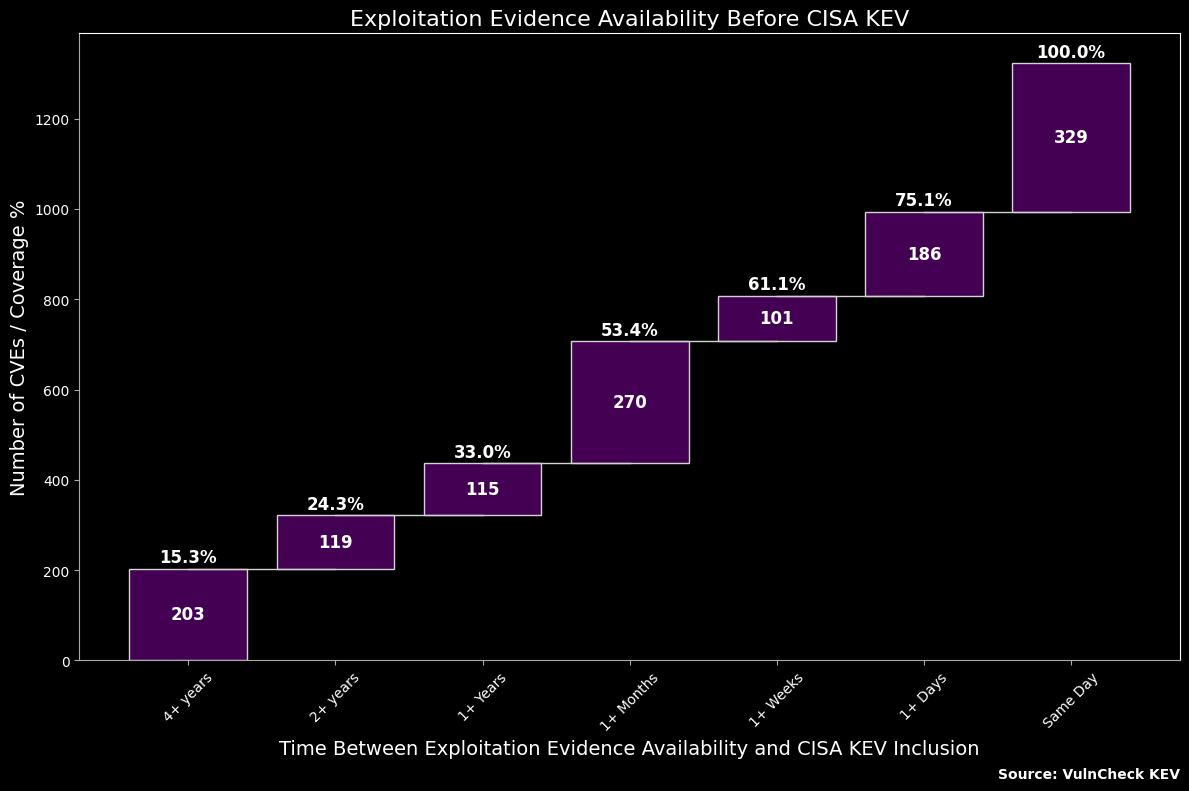

In [25]:
df = df_original.copy()

# Ensure 'Date Added' and 'CISA Date Added' are in datetime format
df['Date Added'] = pd.to_datetime(df['Date Added'], errors='coerce', format='mixed')
df['CISA Date Added'] = pd.to_datetime(df['CISA Date Added'], errors='coerce', format='mixed')

# Calculate 'Days Between' as the difference in days
df['Days Between'] = df.apply(
    lambda row: (row['CISA Date Added'] - row['Date Added']).days if pd.notnull(row['CISA Date Added']) else "none",
    axis=1
)

# Define the function to categorize the time intervals based on 'Days Between'
def categorize_time(days):
    if days == "none":
        return "none"
    elif days >= 1460:
        return '4+ years'
    elif 730 <= days < 1460:
        return '2+ years'
    elif 365 <= days < 730:
        return '1+ Years'
    elif 31 <= days < 365:
        return '1+ Months'
    elif 7 <= days < 31:
        return '1+ Weeks'
    elif 1 <= days < 7:
        return '1+ Days'
    elif days == 0:
        return 'Same Day'
    else:
        return "none"  # Catch any unexpected cases

# Apply the categorization function to create the 'Time' column
df['Time'] = df['Days Between'].apply(categorize_time)

# Group by 'Time' and count occurrences to get the number of CVEs in each time bucket
df_time_counts = df.groupby('Time').size().reindex(
    ['4+ years', '2+ years', '1+ Years', '1+ Months', '1+ Weeks', '1+ Days', 'Same Day'], fill_value=0
).reset_index(name='CVEs')

# Calculate cumulative values and cumulative percentages for the waterfall chart
df_time_counts['Cumulative'] = df_time_counts['CVEs'].cumsum()
total_CVEs = df_time_counts['CVEs'].sum()
df_time_counts['Cumulative %'] = (df_time_counts['Cumulative'] / total_CVEs) * 100

# Define custom colors for dark mode
custom_color = '#440154'
text_color = 'white'
line_color = '#aaaaaa'

# Set dark background
plt.style.use('dark_background')

# Plotting the horizontal waterfall chart with cumulative percentages
fig, ax = plt.subplots(figsize=(12, 8), facecolor='black')
fig.patch.set_facecolor('black')

# Calculate bottom positions for the bars
bottom_positions = df_time_counts['Cumulative'].shift(1).fillna(0)

# Plotting each bar with a lighter color
ax.bar(df_time_counts['Time'], df_time_counts['CVEs'], bottom=bottom_positions, color=custom_color, edgecolor='lightgray')

# Add thicker horizontal lines at the tops of the bars to connect them
for i in range(1, len(df_time_counts)):
    x1 = i - 1
    x2 = i
    y = bottom_positions.iloc[i-1] + df_time_counts['CVEs'].iloc[i-1]
    
    # Draw the connecting horizontal line with increased thickness
    ax.plot([x1, x2], [y, y], color='lightgray', linewidth=1)

# Annotate each bar with its value and cumulative percentage
for i, (time, cves, cum, cum_pct) in enumerate(zip(df_time_counts['Time'], df_time_counts['CVEs'], df_time_counts['Cumulative'], df_time_counts['Cumulative %'])):
    ax.text(i, cum - cves / 2, f'{cves}', ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')
    ax.text(i, cum + 5, f'{cum_pct:.1f}%', ha='center', va='bottom', color=text_color, fontsize=12, fontweight='bold')

# Set title and labels in light color
ax.set_title('Exploitation Evidence Availability Before CISA KEV', fontsize=16, color=text_color)
ax.set_xlabel('Time Between Exploitation Evidence Availability and CISA KEV Inclusion', fontsize=14, color=text_color)
ax.set_ylabel('Number of CVEs / Coverage %', fontsize=14, color=text_color)

# Set x and y axis colors to light gray
ax.tick_params(colors=line_color)
ax.spines['bottom'].set_color(line_color)
ax.spines['left'].set_color(line_color)

ax.text(
    1, -0.17,
    'Source: VulnCheck KEV',
    ha='right', va='top',
    color=text_color,
    fontsize=10,
    fontweight='bold',
    transform=ax.transAxes
)

plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.tight_layout()
plt.show()
